In [1]:
import pandas as pd
import numpy as np
import os
from scipy.spatial.transform import Rotation as R

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
%matplotlib ipympl

In [2]:
from common.transforms import get_tf_manager

tm = get_tf_manager()

In [3]:
from common.config import get_config
config = get_config()

No valid config path given, defaulting to /home/mbandefirvida/Documents/cleanseas/eggers_uxo_datamatching/scripts/common/../config.yaml


In [4]:
ROOT= '../' + config['aris_extract']
DATASET = '2023-09-20_171105'
FILENAME = 'ar3.csv'

In [5]:
df_ar3 = pd.read_csv(os.path.join(ROOT, DATASET, FILENAME))
df_ar3

,aris_frame_idx,pos.x,pos.y,pos.z,rot.x,rot.y,rot.z,rot.w
0,622,0.165015,1.173479,-1.088,0.929728,0.314956,-0.180721,0.061221
1,623,0.165042,1.172802,-1.088,0.929154,0.316647,-0.180609,0.061550
2,624,0.165097,1.171552,-1.088,0.928708,0.317951,-0.180523,0.061803
3,625,0.165183,1.169602,-1.088,0.927984,0.320058,-0.180382,0.062213
4,626,0.165284,1.167383,-1.088,0.927247,0.322187,-0.180239,0.062627
...,...,...,...,...,...,...,...,...
713,1335,2.142072,0.924056,-1.088,0.217151,0.957307,-0.042210,0.186082
714,1336,2.143628,0.927152,-1.088,0.216797,0.957388,-0.042141,0.186097
715,1337,2.145554,0.931040,-1.088,0.216435,0.957469,-0.042071,0.186113
716,1338,2.146880,0.933994,-1.088,0.216169,0.957530,-0.042019,0.186125


In [6]:
from pytransform3d.plot_utils import make_3d_axis
import pytransform3d.transformations as pytr
from pytransform3d import visualizer as pv

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [7]:
ROOT_MESH = os.path.join('..', '..', '3d_models')
SCALING=20

fig = pv.figure()
fig.plot_mesh(filename=os.path.join(ROOT_MESH, "100lbs_aircraft_bomb/100lbs_aircraft_bomb.stl"), s=np.ones(3), A2B=tm.get_transform("target/100lbs", "world"))

fig.plot_transform(A2B=tm.get_transform("target/100lbs", "world"), s=0.2)

for index, row in df_ar3.iloc[::SCALING].iterrows():

    tm.add_transform("setup/ar3", "world", A2B=pytr.transform_from(R.from_quat(row[['rot.x','rot.y', 'rot.z', 'rot.w']]).as_matrix(), row[['pos.x','pos.y', 'pos.z']]))
    fig.plot_transform(A2B=tm.get_transform("setup/camera", "world"), s=0.2)

fig.show()

---
## Camera tilt

In [9]:
import cv2

In [10]:
ROOT_IMG = '/home/mbandefirvida/Documents/cleanseas/datasets/eggers_kampfmittelbergung-aris3000-black_basin/2023-09-20_171105/gopro/restored'
FRAME_ID = 1211
row = df_ar3[df_ar3.aris_frame_idx == FRAME_ID]
row

,aris_frame_idx,pos.x,pos.y,pos.z,rot.x,rot.y,rot.z,rot.w
589,1211,1.848146,0.627722,-1.088,0.407265,0.893156,-0.079164,0.173612


In [11]:
tm.add_transform("setup/ar3", "world", A2B=pytr.transform_from(R.from_quat(row[['rot.x','rot.y', 'rot.z', 'rot.w']]).as_matrix(), row[['pos.x','pos.y', 'pos.z']]))

In [12]:
ROOT_MESH = os.path.join('..', '..', '3d_models')
SCALING=20

fig = pv.figure()
fig.plot_mesh(filename=os.path.join(ROOT_MESH, "100lbs_aircraft_bomb/100lbs_aircraft_bomb.stl"), s=np.ones(3), A2B=tm.get_transform("target/100lbs", "world"))

fig.plot_transform(A2B=tm.get_transform("target/100lbs", "world"), s=0.2)
fig.plot_transform(A2B=tm.get_transform("setup/camera", "world"), s=0.2)

fig.show()

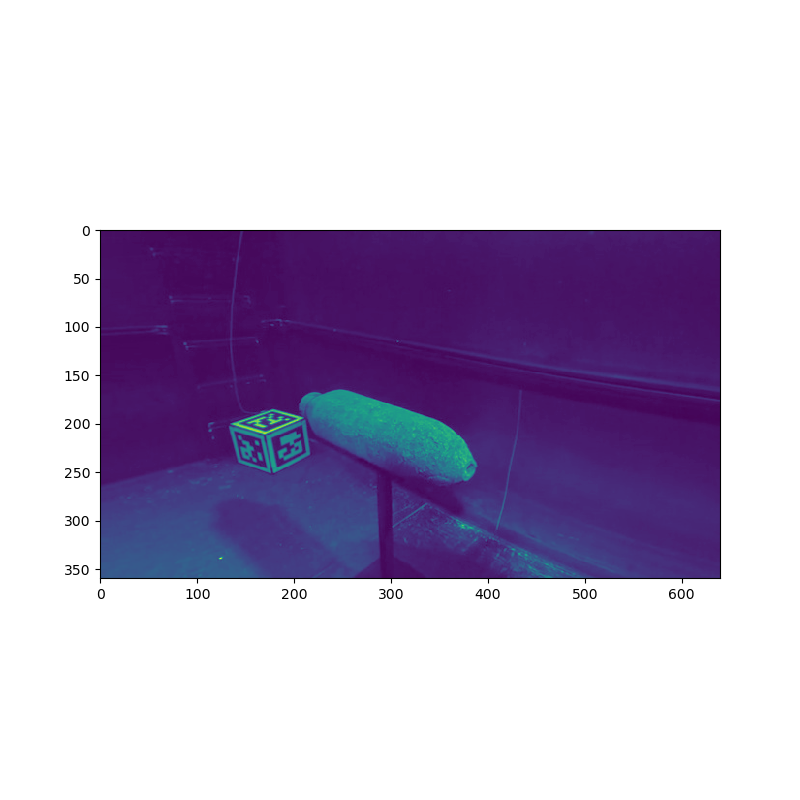

In [13]:
ROOT_IMG = '/home/mbandefirvida/Documents/cleanseas/datasets/eggers_kampfmittelbergung-aris3000-black_basin/2023-09-20_171105/gopro/restored'
image = cv2.imread(os.path.join(ROOT_IMG, str(FRAME_ID) + ".jpg"))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# The following plots the waterfall-view in separate subplots
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(gray)

In [14]:
import  apriltag

options = apriltag.DetectorOptions(families="tag36h11")
detector = apriltag.Detector(options)
results = detector.detect(gray)
print("[INFO] {} total AprilTags detected".format(len(results)))

[INFO] 3 total AprilTags detected


In [15]:
for r in results:
  # extract the bounding box (x, y)-coordinates for the AprilTag
  # and convert each of the (x, y)-coordinate pairs to integers
  (ptA, ptB, ptC, ptD) = r.corners
  ptB = (int(ptB[0]), int(ptB[1]))
  ptC = (int(ptC[0]), int(ptC[1]))
  ptD = (int(ptD[0]), int(ptD[1]))
  ptA = (int(ptA[0]), int(ptA[1]))
  # draw the bounding box of the AprilTag detection
  cv2.line(image, ptA, ptB, (0, 255, 0), 2)
  cv2.line(image, ptB, ptC, (0, 255, 0), 2)
  cv2.line(image, ptC, ptD, (0, 255, 0), 2)
  cv2.line(image, ptD, ptA, (0, 255, 0), 2)
  # draw the center (x, y)-coordinates of the AprilTag
  (cX, cY) = (int(r.center[0]), int(r.center[1]))
  #cv2.circle(image, (cX, cY), 5, (0, 0, 255), -1)
  # draw the tag family on the image
  tagId = str(r.tag_id)
  tagFamily = r.tag_family.decode("utf-8")
  print(r.homography)
  cv2.putText(image, "Tag " + tagId, (cX, cY),
    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
  print("[INFO] tag family: {}".format(tagFamily))
# show the output image after AprilTag detection


[[ 1.15928036e+00  5.27963776e-01 -7.68740844e+00]
 [ 1.99452474e-01  1.02990878e-01 -8.70356065e+00]
 [ 2.39490721e-03 -3.23256559e-04 -4.39710438e-02]]
[INFO] tag family: tag36h11
[[-5.59280854e-01 -2.39892872e-01 -7.30461374e+00]
 [-8.80540966e-02 -8.21687792e-01 -1.06902663e+01]
 [ 5.34494330e-04 -4.63861684e-04 -4.69973189e-02]]
[INFO] tag family: tag36h11
[[-2.67326479e-01  9.89472356e-01  8.52850724e+00]
 [-8.27874386e-01  3.91397762e-02  9.73247268e+00]
 [-7.88267843e-04  1.59948125e-03  4.35320787e-02]]
[INFO] tag family: tag36h11


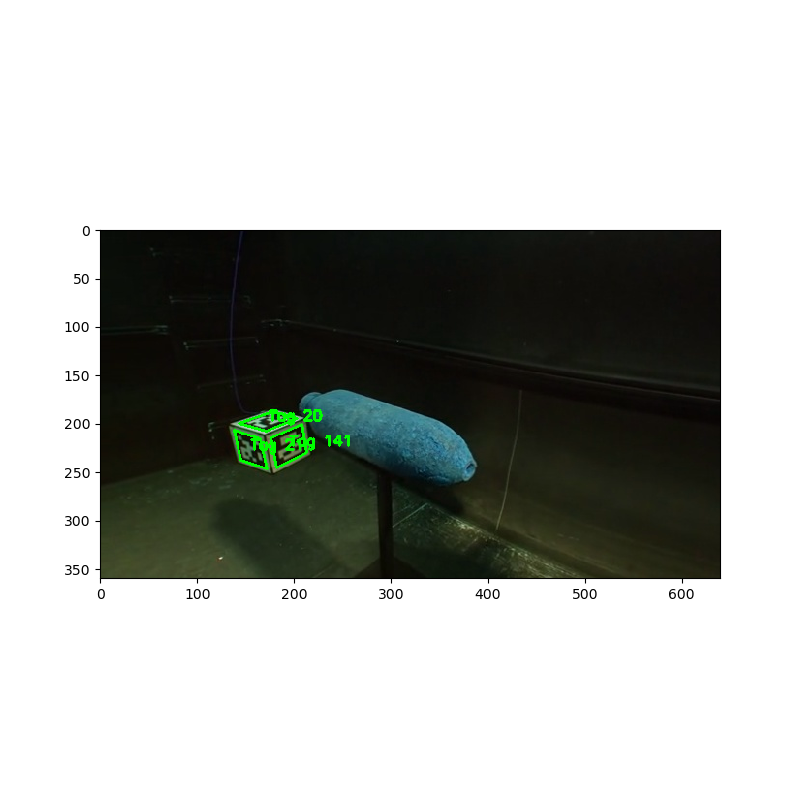

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image)

In [ ]:
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.text import Annotation


class Annotation3D(Annotation):
    '''Annotate the point xyz with text s'''

    def __init__(self, s, xyz, *args, **kwargs):
        Annotation.__init__(self,s, xy=(0,0), *args, **kwargs)
        self._verts3d = xyz        

    def draw(self, renderer):
        xs, ys, zs = proj_transform(self._verts3d[0], self._verts3d[1], self._verts3d[2], renderer.M)
        self.xy=(xs,ys)
        Annotation.draw(self, renderer)
        
def annotate3D(ax, s, *args, **kwargs):
    '''add anotation text s to to Axes3d ax'''
    tag = Annotation3D(s, *args, **kwargs)
    ax.add_artist(tag)

In [63]:
# https://en.wikipedia.org/wiki/Camera_resectioning
K = np.array([[431.5790272011588, 0.0, 325.5650847006285],
              [0.0, 425.7563760783507, 160.3434930783429],
              [0.0, 0.0, 1.0]])

fx, fy = K[0,0], K[1,1]
cx, cy = K[2,0], K[2,1]

In [68]:

tfs = []
for result in results:
    pose = detector.detection_pose(result, [fx, fy, cx, cy],  tag_size=0.30)
    tf = pose[0]

    #NOTE: transform to camera frame
    tf[:3,3] = [-tf[1,3], tf[0,3], tf[2,3]]
    tfs.append(tf)

tfs = np.array(tfs)

In [69]:
np.array(tfs).round(4)

array([[[-0.9486, -0.2084,  0.238 , -1.5684],
        [ 0.1912,  0.2217,  0.9562,  1.5317],
        [-0.2521,  0.9526, -0.1704,  3.4175],
        [ 0.    ,  0.    ,  0.    ,  1.    ]],

       [[ 0.4669,  0.1771,  0.8664, -2.2782],
        [-0.1325,  0.9827, -0.1295,  1.7645],
        [-0.8743, -0.0543,  0.4823,  4.3432],
        [ 0.    ,  0.    ,  0.    ,  1.    ]],

       [[-0.2283,  0.9379, -0.2612, -1.8695],
        [-0.9476, -0.2757, -0.1617,  1.7771],
        [-0.2236,  0.2106,  0.9516,  3.602 ],
        [ 0.    ,  0.    ,  0.    ,  1.    ]]])

In [70]:
tf = tfs[0]
[tf[1,3], -tf[0,3], tf[2,3]]

[1.531716991633282, 1.5684207179749665, 3.417528011059582]

In [71]:
for tf, result in zip(tfs,results):
    tf[:3,3] = [tf[3,1], -tf[3,0], tf[3,3]]
    print(tf)

[[-0.94862659 -0.20842904  0.23804396  0.        ]
 [ 0.19123662  0.22166854  0.95618597 -0.        ]
 [-0.25206378  0.95258616 -0.17042141  1.        ]
 [ 0.          0.          0.          1.        ]]
[[ 0.46691774  0.17712542  0.86638006  0.        ]
 [-0.13246162  0.98268985 -0.12951668 -0.        ]
 [-0.87432359 -0.05428847  0.48229764  1.        ]
 [ 0.          0.          0.          1.        ]]
[[-0.22829238  0.9378957  -0.26121686  0.        ]
 [-0.94755841 -0.27567227 -0.16167207 -0.        ]
 [-0.22364178  0.21060973  0.95164484  1.        ]
 [ 0.          0.          0.          1.        ]]


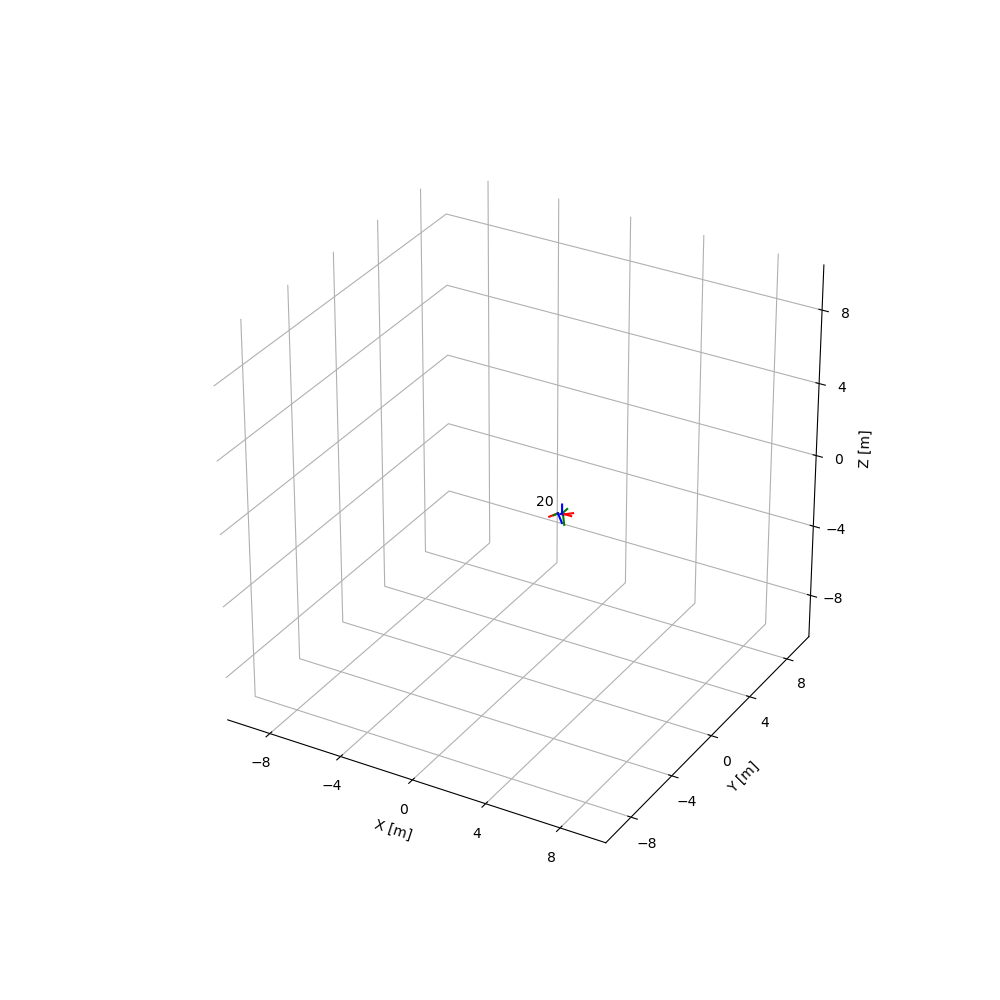

In [72]:
from pytransform3d.plot_utils import make_3d_axis
import pytransform3d.transformations as pytr
from mpl_toolkits import mplot3d

figure = plt.figure(figsize=(10,10))
ax = mplot3d.Axes3D(figure)
ax = make_3d_axis(ax_s=10, unit="m", n_ticks=6)


for tf, result in zip(tfs,results):
    
    tm.add_transform("marker/" + str(result.tag_id), "setup/camera", A2B=tf)

    tf_from_world = tm.get_transform("marker/" + str(result.tag_id), "world")

    pytr.plot_transform(ax, A2B=tf_from_world, s=0.5)

    annotate3D(ax, s=str(result.tag_id), xyz=tf_from_world[:3,3], fontsize=10, xytext=(-3,3), textcoords='offset points', ha='right',va='bottom')
    break

pytr.plot_transform(ax, A2B=tm.get_transform("setup/camera", "world"), s=0.5)
pytr.plot_transform(ax, A2B=tm.get_transform("target/100lbs", "world"), s=0.5)
plt.show()

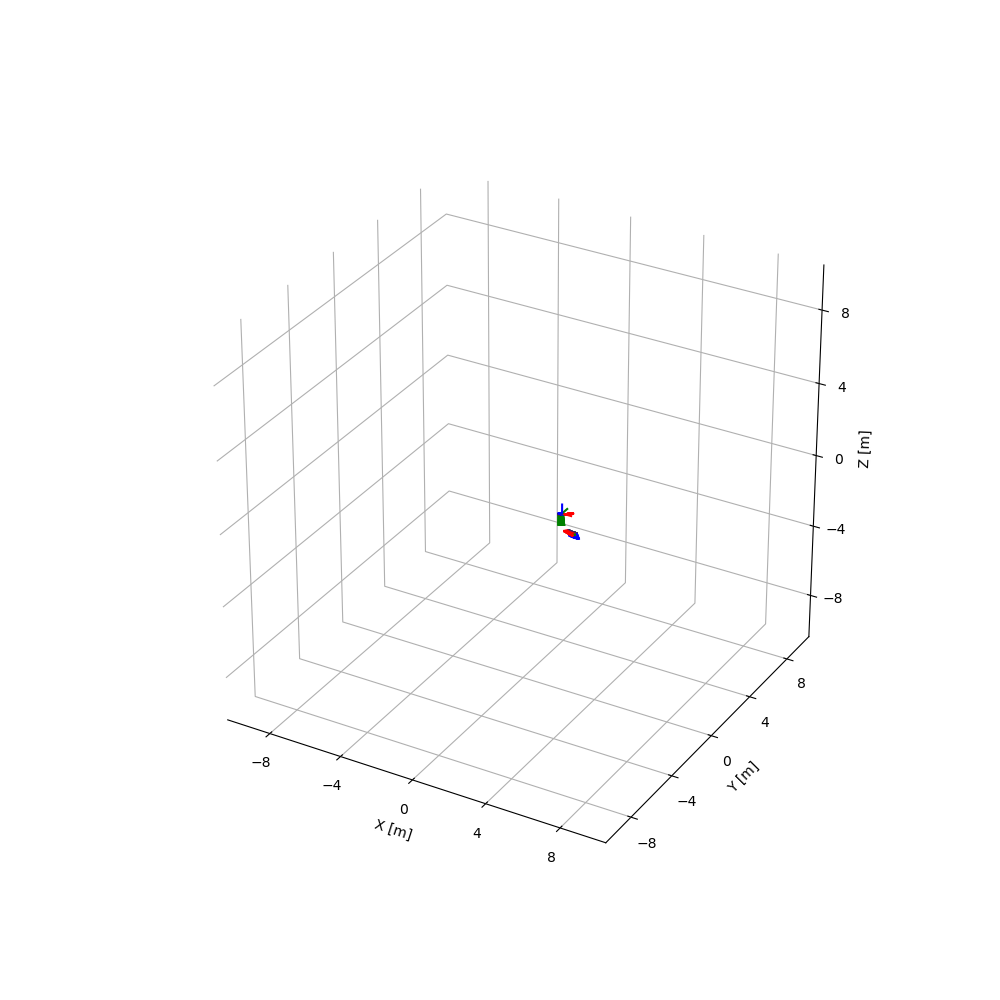

In [73]:
figure = plt.figure(figsize=(10,10))
ax = mplot3d.Axes3D(figure)
ax = make_3d_axis(ax_s=10, unit="m", n_ticks=6)

for i in range(1150,1228):
    row = df_ar3[df_ar3.aris_frame_idx == i]
    
    image = cv2.imread(os.path.join(ROOT_IMG, str(i) + ".jpg"))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    options = apriltag.DetectorOptions(families="tag36h11")
    detector = apriltag.Detector(options)
    results = detector.detect(gray)

    for result in results:
        if result.tag_id == 20:
            pose = detector.detection_pose(result, [fx, fy, cx, cy],  tag_size=0.247)
            
            tm.add_transform("setup/ar3", "world", A2B=pytr.transform_from(R.from_quat(row[['rot.x','rot.y', 'rot.z', 'rot.w']]).as_matrix(), row[['pos.x','pos.y', 'pos.z']]))

            tm.add_transform("marker/" + str(result.tag_id), "setup/camera", A2B=pose[0])

            tf_from_world = tm.get_transform("marker/" + str(result.tag_id), "world")

            pytr.plot_transform(ax, A2B=tf_from_world, s=0.25)
            pytr.plot_transform(ax, A2B=tm.get_transform("setup/camera", "world"), s=0.5)

    # annotate3D(ax, s=str(result.tag_id), xyz=tf_from_world[:3,3], fontsize=10, xytext=(-3,3), textcoords='offset points', ha='right',va='bottom')

pytr.plot_transform(ax, A2B=tm.get_transform("target/100lbs", "world"), s=0.5)
plt.show()

